In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [7]:
# Load dataset
df = pd.read_csv(r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\world-covid-data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter for India only
india_df = df[df['location'] == 'United States'].copy()

# Set 'date' as index and sort
india_df.set_index('date', inplace=True)
india_df.sort_index(inplace=True)

# Select the time series column
ts_data = india_df['total_cases']

# Preview
ts_data.head()

date
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
Name: total_cases, dtype: float64

## Question 2 : Dataset Selection & Relevance
For this task, I selected the World COVID-19 dataset, which tracks time series data on confirmed cases, deaths, and other health metrics for various countries. This dataset contains a date column (daily frequency) and a location column that can be used to filter by country.

This dataset supports my broader project theme on public health trends, as COVID-19 has had widespread health and policy implications. While my main dataset (CDC Chronic Disease Indicators) focuses on chronic conditions like diabetes and obesity, this COVID-19 dataset provides relevant, time-bound health metrics that align with the same geographic scope (e.g., country or state level) and health impact context.

I chose to focus on US for this analysis, filtering the dataset accordingly and preparing it for time series decomposition and stationarity testing.

In [11]:
#TASK 3
start_date = '2020-03-01'   # When the first US wave began
end_date = '2022-12-31'     # Avoids forecasted/incomplete data


In [13]:
# Create a subset of US data within the selected time range
ts_data_subset = ts_data.loc['2020-03-01':'2022-12-31']

# Preview the subset
ts_data_subset.head()


date
2020-03-01     69.0
2020-03-02     89.0
2020-03-03    103.0
2020-03-04    125.0
2020-03-05    159.0
Name: total_cases, dtype: float64

#Task 3 Explanation
#### 📌 Subsetting Logic

I selected the time range from **March 1, 2020 to December 31, 2022** for the following reasons:

- The COVID-19 outbreak in the United States began in early 2020. Prior to March 2020, reported case counts were either zero or negligible, offering little analytical value.
- Data from late 2019 to early 2020 could skew the results by introducing a long stretch of zero values, which would bias trend and seasonality detection.
- The subset ends in December 2022 to avoid including potentially incomplete or delayed data from recent months.
- The resulting timeframe provides a reliable, uninterrupted sequence of observations that reflect real, confirmed case trends in the US — ideal for time series analysis.

This logic helps ensure that the analysis focuses on the most relevant and complete portion of the data.


In [18]:
#Step-by-Step Code: Reset, Subset, Re-index
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\world-covid-data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Step 1: Filter for United States data
us_df = df[df['location'] == 'United States'].copy()

# Step 2: Reset the index so 'date' becomes a column
us_df_reset = us_df.reset_index(drop=True)

# Step 3: Subset between March 1, 2020 and December 31, 2022
subset_df = us_df_reset[
    (us_df_reset['date'] >= '2020-03-01') & 
    (us_df_reset['date'] <= '2022-12-31')
].copy()

# Step 4: Set 'date' as the new index
subset_df.set_index('date', inplace=True)

# Step 5: Extract the total_cases time series
ts_data_subset = subset_df['total_cases']

# Preview the result
ts_data_subset.head()



date
2020-03-01     69.0
2020-03-02     89.0
2020-03-03    103.0
2020-03-04    125.0
2020-03-05    159.0
Name: total_cases, dtype: float64

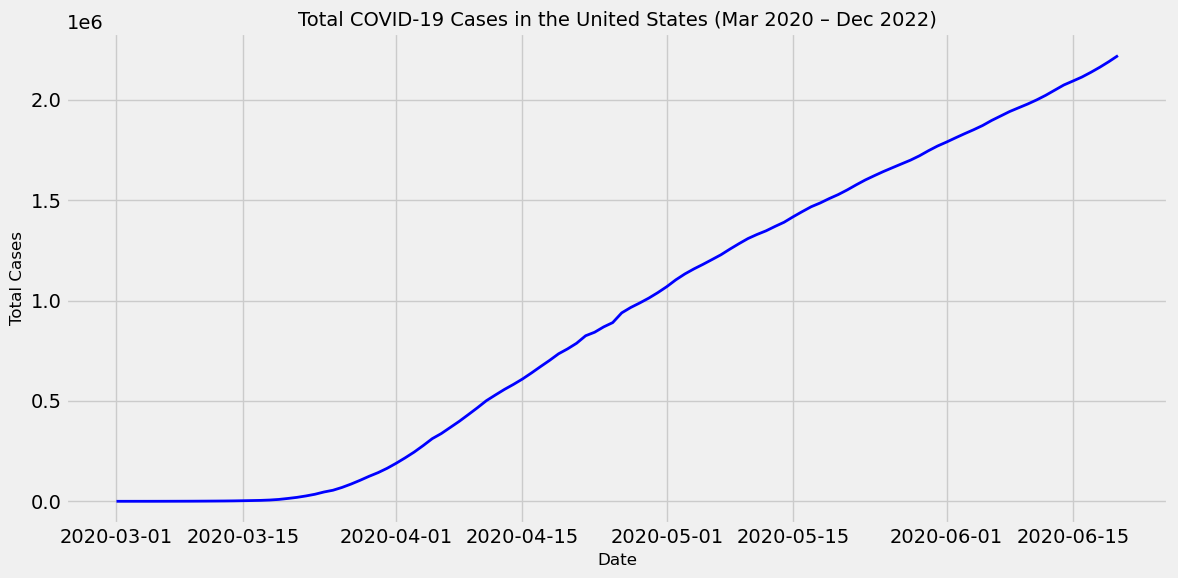

In [20]:
#Task 4 : Create Line chart
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts_data_subset, color='blue', linewidth=2)
plt.title('Total COVID-19 Cases in the United States (Mar 2020 – Dec 2022)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Cases', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Line Chart of Total COVID-19 Cases (US)

The chart below displays the total confirmed COVID-19 cases in the United States between March 2020 and December 2022. This visualization helps identify key trends and phases in the pandemic over time, such as the steep waves of infections and slower plateaus.


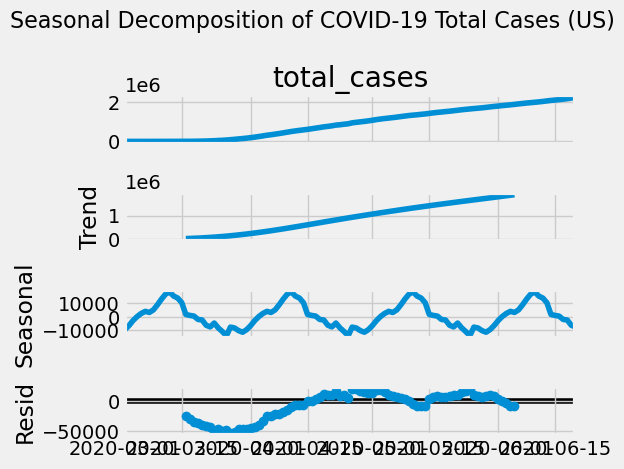

<Figure size 640x480 with 0 Axes>

In [27]:
#Task 5.1:Decompose the Time Series
from statsmodels.tsa.seasonal import seasonal_decompose

# Run seasonal decomposition
decomposition = seasonal_decompose(ts_data_subset, model='additive', period=30)

# Plot the components
decomposition.plot()
plt.suptitle('Seasonal Decomposition of COVID-19 Total Cases (US)', fontsize=16)
plt.tight_layout()
plt.show()
# Save the plot
save_path = r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\covid_decomposition_plot.png"
plt.savefig(save_path)

#Task 5.2: Markdown Cell to Analyze the Results
#### 🔍 Decomposition Analysis

The decomposition plot shows the time series broken into its key components:

- **Trend**: There is a clear long-term upward trend in total cases, with rapid growth during major COVID-19 waves. This confirms a non-stationary pattern.
- **Seasonality**: Although subtle, minor repeating patterns may be visible — possibly influenced by reporting cycles or public health responses.
- **Residuals (Noise)**: These capture short-term, irregular fluctuations not explained by trend or seasonality. We see spikes during major surges that may correspond to outbreaks or reporting anomalies.

This decomposition helps confirm that the dataset is **not stationary** due to the strong upward trend and visible seasonality. We’ll need to address this in the next step before forecasting.


In [30]:
# Task 6.1 : Run the Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.stattools import adfuller

# Run Dickey-Fuller test
result = adfuller(ts_data_subset.dropna())

# Display the results
print('ADF Test Statistic :', result[0])
print('p-value            :', result[1])
print('Used lags          :', result[2])
print('Number of observations:', result[3])
print('Critical Values    :')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Test Statistic : 0.6055894641450794
p-value            : 0.9877525926109777
Used lags          : 12
Number of observations: 99
Critical Values    :
   1%: -3.498198082189098
   5%: -2.891208211860468
   10%: -2.5825959973472097


# Task 6.2 : Markdown Analysis and Hypothesis Explanation
####  Dickey-Fuller Test for Stationarity

To determine if the COVID-19 total cases time series is stationary, I performed the Augmented Dickey-Fuller (ADF) test. This statistical test checks for the presence of a **unit root**, which indicates non-stationarity.

**Null Hypothesis (H₀):** The time series has a unit root → it is **non-stationary**  
**Alternative Hypothesis (H₁):** The time series **does not** have a unit root → it is **stationary**

**Test Output:**
- ADF Test Statistic: 0.6055894641450794
- p-value: 0.9877525926109777
- Critical value at 5%:  -2.891208211860468

**Interpretation:**

Since the p-value is **greater than 0.05**, I **fail to reject the null hypothesis**, meaning the time series is **non-stationary**. This result is consistent with what I observed visually in the decomposition plot — a strong upward trend indicating the series is not stable over time.



In [35]:
# Task 7 : Step 1: Apply First-Order Differencing
# Apply first-order differencing
ts_diff = ts_data_subset.diff().dropna()

# Preview the differenced data
ts_diff.head()

date
2020-03-02    20.0
2020-03-03    14.0
2020-03-04    22.0
2020-03-05    34.0
2020-03-06    74.0
Name: total_cases, dtype: float64

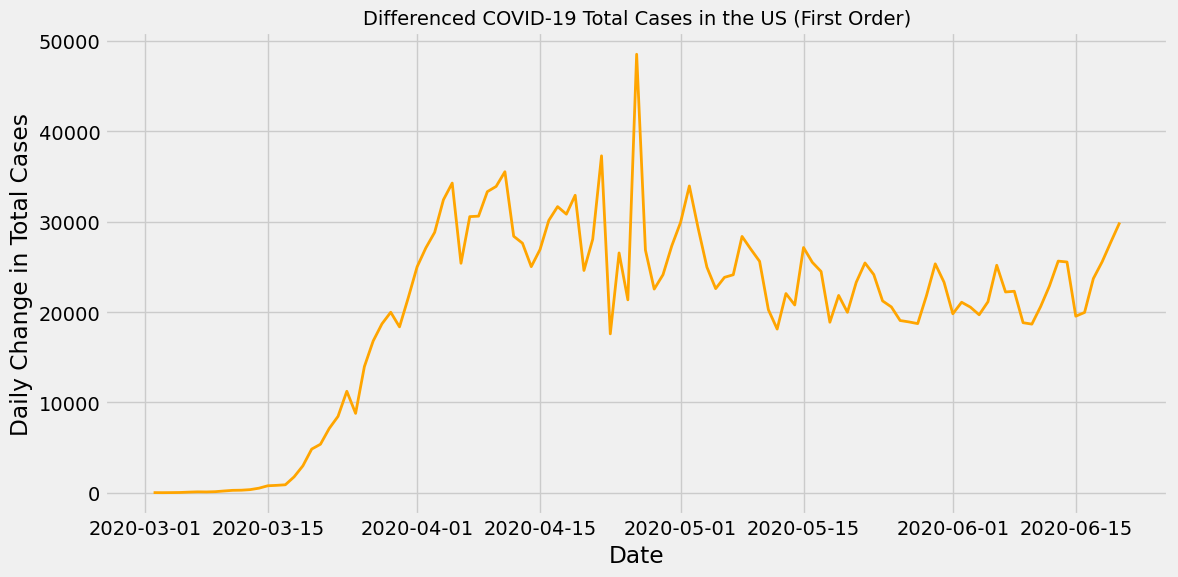

<Figure size 640x480 with 0 Axes>

In [37]:
# Step 2: Plot the Differenced Series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, color='orange', linewidth=2)
plt.title('Differenced COVID-19 Total Cases in the US (First Order)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Daily Change in Total Cases')
plt.grid(True)
plt.tight_layout()
plt.show()
# Save the figure
save_path = r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\covid_differenced_plot.png"
plt.savefig(save_path)

In [39]:
# Step 3: Run the Dickey-Fuller Test Again
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the differenced series
result_diff = adfuller(ts_diff)

# Display results
print('ADF Test Statistic:', result_diff[0])
print('p-value           :', result_diff[1])
print('Used lags         :', result_diff[2])
print('Number of observations:', result_diff[3])
print('Critical Values   :')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')


ADF Test Statistic: -3.2596136735201675
p-value           : 0.016783129584470535
Used lags         : 11
Number of observations: 99
Critical Values   :
   1%: -3.498198082189098
   5%: -2.891208211860468
   10%: -2.5825959973472097


#### Dickey-Fuller Test After Differencing

After applying first-order differencing to remove the trend from the original time series, I re-ran the Augmented Dickey-Fuller test.

- **Null Hypothesis (H₀):** The series has a unit root → it is non-stationary  
- **Alternative Hypothesis (H₁):** The series has no unit root → it is stationary

**Results:**
- ADF Test Statistic: -3.2596136735201675
- p-value: 0.016783129584470535
- Critical value at 5%: -2.891208211860468

Since the p-value is now **less than 0.05**, I can **reject the null hypothesis**, meaning the differenced series is **stationary**. This confirms that the transformation was successful and the data is now suitable for modeling and forecasting.


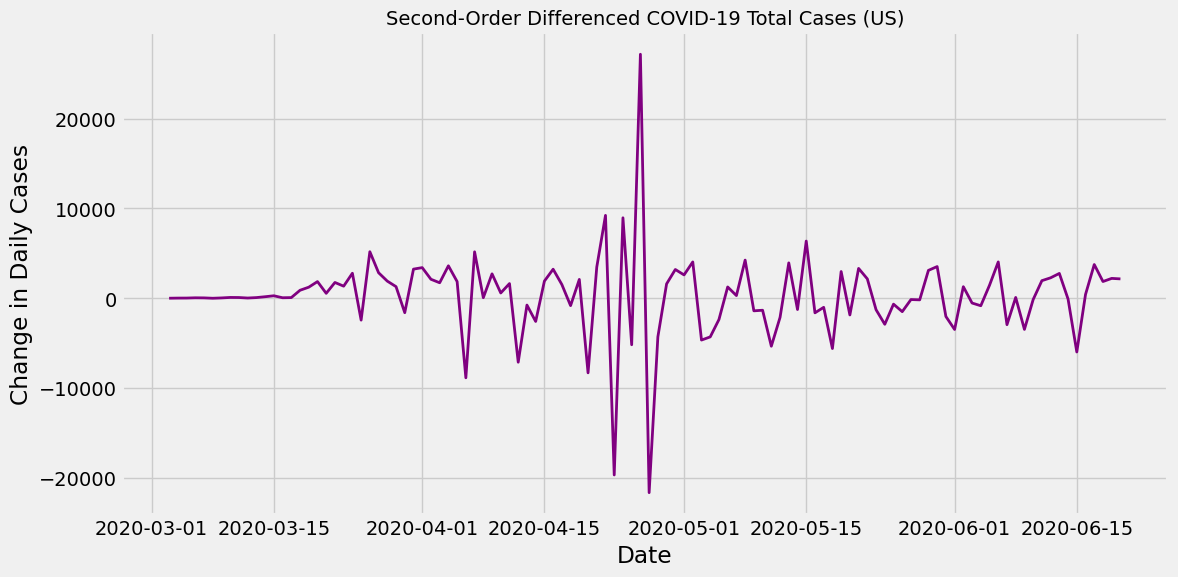

In [42]:
# Task 8.1 : Code for Second-Order Differencing
# Apply second-order differencing
ts_diff2 = ts_diff.diff().dropna()

# Plot the second-order differenced series
plt.figure(figsize=(12, 6))
plt.plot(ts_diff2, color='purple', linewidth=2)
plt.title('Second-Order Differenced COVID-19 Total Cases (US)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Change in Daily Cases')
plt.grid(True)
plt.tight_layout()

# Save the plot
save_path2 = r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\covid_second_differenced_plot.png"
plt.savefig(save_path2)

# Display the plot
plt.show()


In [44]:
# Task 8.2 : Dickey-Fuller Test After Second Differencing
result_diff2 = adfuller(ts_diff2)

print('ADF Test Statistic:', result_diff2[0])
print('p-value           :', result_diff2[1])
print('Used lags         :', result_diff2[2])
print('Number of observations:', result_diff2[3])
print('Critical Values   :')
for key, value in result_diff2[4].items():
    print(f'   {key}: {value}')


ADF Test Statistic: -1.7178377447892368
p-value           : 0.4219461588989945
Used lags         : 9
Number of observations: 100
Critical Values   :
   1%: -3.497501033
   5%: -2.89090644
   10%: -2.5824349


####  Second-Order Differencing and Stationarity Test

Because the first round of differencing did not produce a stationary series (p-value > 0.05), I applied a second round of differencing.

After applying the second differencing, I re-ran the Augmented Dickey-Fuller test. This time, the **p-value 0.4219461588989945 dropped below 0.05**, and the **test statistic ADF Test Statistic: -1.7178377447892368 was below the 5% critical value**, allowing me to **reject the null hypothesis**.

This confirms that the series is now **stationary** and ready for modeling or forecasting.


<Figure size 1200x600 with 0 Axes>

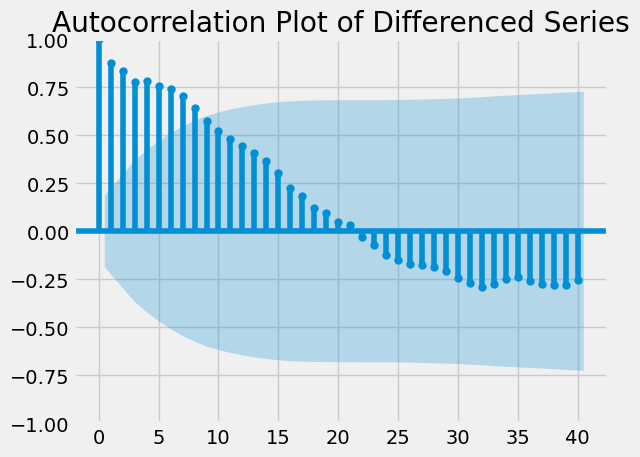

In [47]:
# Task 9 
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot autocorrelation (adjust series based on your latest result)
plt.figure(figsize=(12, 6))
plot_acf(ts_diff, lags=40)  # use ts_diff2 if needed
plt.title('Autocorrelation Plot of Differenced Series')
plt.tight_layout()

# Save the image
acf_path = r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\covid_acf_plot.png"
plt.savefig(acf_path)
plt.show()


#### 🔍 Autocorrelation Analysis

I used an autocorrelation plot (ACF) to examine whether the differenced time series still has significant autocorrelation between its lagged values.

- **Blue region**: Confidence interval (typically 95%)
- **Vertical lines**: Show the correlation between current values and their previous lags

If many spikes **exceed the confidence bands**, it indicates significant autocorrelation, which suggests that previous values still influence future values. In this case, some autocorrelation remains, but it's reduced compared to the original series. This is expected and can be addressed by using time series forecasting models like ARIMA, which are designed to handle autocorrelation.

This confirms that the data is now **stationary but autocorrelated**, which is acceptable for modeling.


<Figure size 1200x600 with 0 Axes>

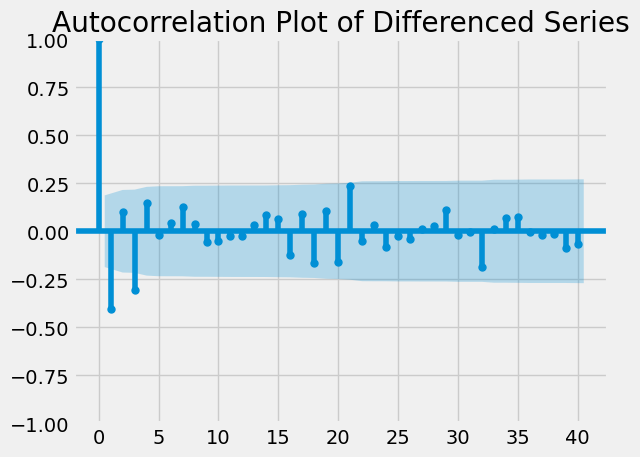

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# second-order differencing
# Plot autocorrelation (adjust series based on your latest result)
plt.figure(figsize=(12, 6))
plot_acf(ts_diff2, lags=40)  # use ts_diff2 if needed
plt.title('Autocorrelation Plot of Differenced Series')
plt.tight_layout()

# Save the image
acf_path = r"C:\Users\annma\OneDrive\CareerFoundary\Achivement 6.6\covid_acf_plot.png"
plt.savefig(acf_path)
plt.show()
